In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time

from nearly_nmf import nmf
rng = np.random.default_rng(100921)


In [2]:
delta_x = 0.1
n_pad_pixel = 70
remove_pad = np.s_[n_pad_pixel:-n_pad_pixel]
pad_lamb = delta_x * n_pad_pixel * 2

x_pad = np.arange(1210 - pad_lamb, 1247 + pad_lamb, delta_x)
x = x_pad[remove_pad]

# This puts them in vaguely the same pixel/subpixel location
# So the scaling between the two is equivalent
mu_1 = x[remove_pad][2 * len(x[remove_pad]) // 5]
delta_mu = 10
mu_2 = mu_1 + delta_mu

add_continuum = False

# Approximating a delta function with a super narrow gaussian
emission_sigma = 0.5
continuum_slope = -0.15

In [3]:
def gauss(x, mu, sigma, scale):
    factor = np.exp(-0.5*((x - mu) / sigma)**2)
    return scale * factor

In [4]:
def continuum(x, mu, slope, shift):
    return slope * (x - mu) + shift

In [5]:
def psf_matrix_from_psf(psf):
    # Turns the PSF into a square matrix that can be matmul'd with the spectra
    # to perform the PSF convolution operation
    G = np.zeros((len(x_pad), len(x_pad) + len(psf) - 1))

    psf_pad = np.pad(psf, (0, len(x_pad) - 1))
    for i in range(G.shape[0]):
        G[i] = np.roll(psf_pad, i)

    return G.T[len(psf)//2:-len(psf)//2 + 1]

Text(0.5, 1.0, 'PSF')

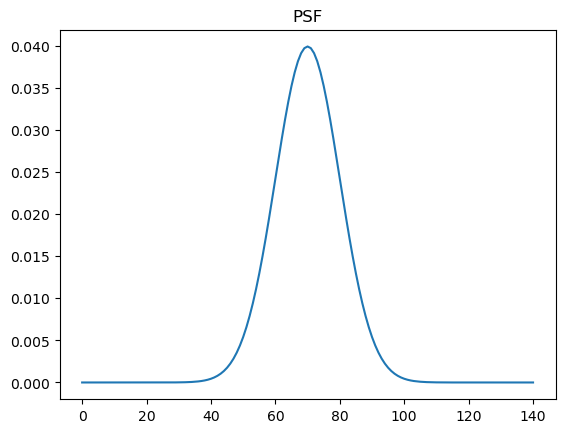

In [6]:
# This is a vaguely reasonable PSF, not too dissimilar from a randomly picked one.
# I've made it a little broader in this example.
psf_grid = np.arange(-7, 7+delta_x, delta_x)
psf = gauss(psf_grid, 0, 1, 1)
psf /= sum(psf) # Needs to sum to 1 to be valid

plt.plot(psf)

plt.title("PSF")

In [7]:
n_exps = 500

# We don't vary the scale, and instead vary the SNR
# by varying the std of the noise each exposure gets
scales = rng.uniform(150, 150, n_exps)
noise_sigmas = rng.uniform(10, 15, n_exps)

# Varying the scale of the second gaussian to vary
# the ratio between 2:1 and 1:2
scale_2_vary = rng.uniform(0.5, 2, n_exps)

In [8]:
data = []
data_psf = []

exposure_psfs = []
ivar_psf = []

# For the first pass we will aslo have the same PSF in every "exposure"
# and for every pixel. Not realistic but good enough.
for i, s in enumerate(scales):
    # Zero mean noise
    noise_lamb = noise_sigmas[i]
    noise = rng.normal(0, noise_lamb, x.shape) #rng.poisson(noise_lamb, x.shape) - noise_lamb
    
    y = gauss(x_pad, mu_1, emission_sigma, s) + scale_2_vary[i] * gauss(x_pad, mu_2, emission_sigma, s) + add_continuum * continuum(x_pad, 1270, continuum_slope, 1)
    # y = y.clip(min=0)
    
    
    # Applying the point spread function
    psf_sigma = 1.9#sigma_vary[i]
    psf = gauss(psf_grid, 0, psf_sigma, 1)
    psf /= np.sum(psf)
    G = psf_matrix_from_psf(psf)
    
    # Psf will go out of the grid and bring in from outside the grid
    # that's why x_pad exists so we use pixels outside the fitting range to
    # avoid edge effects
    y_psf = (G @ y)[remove_pad]
    data.append(y_psf)
    y_poisson_psf = rng.poisson(y_psf)
    data_psf.append(y_poisson_psf + noise)
    ivar_psf.append(1 / (y_poisson_psf + noise_lamb ** 2))
    
    # Need to chop out the padding on the reported matrix for fitting
    exposure_psfs.append(G[None, remove_pad, remove_pad])
    
data = np.vstack(data)
data_psf = np.vstack(data_psf)
ivar_psf = np.nan_to_num(np.vstack(ivar_psf), nan=0, posinf=0)
exposure_psfs = np.vstack(exposure_psfs)

X = data_psf.T
V = ivar_psf.T

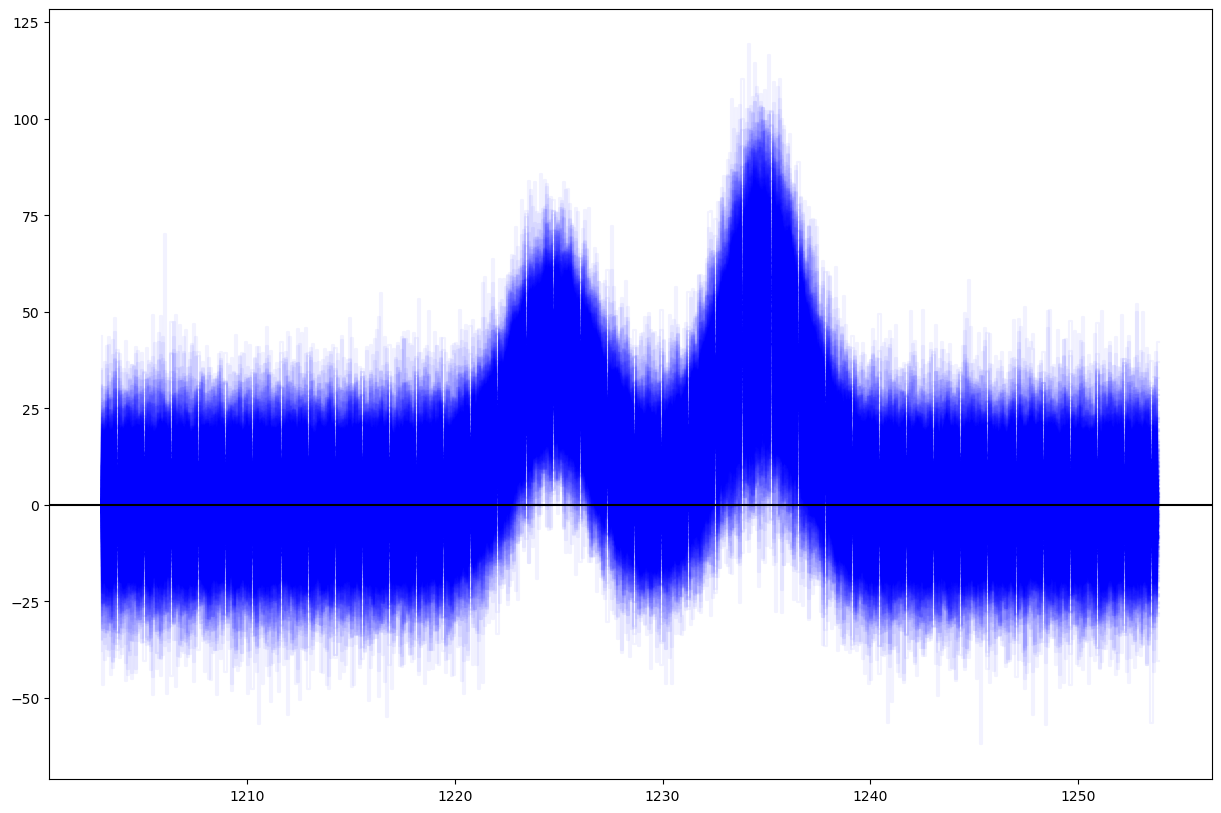

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
for i in range(len(data)):
    plt.step(x, X[:, i], alpha=0.05, c="b")
    
plt.axhline(y=0, c="k")
# plt.savefig("plots/data.pdf", bbox_inches="tight", dpi=256)

In [10]:
# Weighted "regular" NMF implementation
def NMF_solve(X, V, H_start, W_start, n_iter=500):
    H = np.array(H_start, copy=True)
    W = np.array(W_start, copy=True)

    # Chi^2 history
    chi_2 = []
    
    # Precomputing some values for efficiency
    V_X = V * X
    chi_2 = []
    for j in range(n_iter):
        H = H * (W.T @ V_X) / (W.T @ (V * (W @ H)))
        H = np.nan_to_num(H, nan=0, posinf=0)

        W = W * (V_X @ H.T) / ((V * (W @ H)) @ H.T)
        W = np.nan_to_num(W, nan=0, posinf=0)

        c2 = np.linalg.norm(V * (X - W @ H))
        chi_2.append(c2)
        
        
    return H, W,chi_2

In [11]:
rng = np.random.default_rng(100921)

# Abstracting this variable
n_templates = 2

H_shape = (n_templates, X.shape[1])
W_shape = (X.shape[0], n_templates)

H_start = rng.uniform(0, 1, H_shape)
W_start = np.ones(W_shape)

In [12]:
# Start all three algorithms from the same starting point
H_nearly, W_nearly, chi_nearly = nmf.nearly_NMF(X, V, H_start, W_start, n_iter=300, return_chi_2=True)
H_shift, W_shift, chi_shift = nmf.shift_NMF(X, V, H_start, W_start, n_iter=300, return_chi_2=True)
H_reg, W_reg, _ = NMF_solve(X.clip(min=0), V, H_start, W_start, n_iter=300)

/pscratch/sd/d/dylang/repos/nmf_with_negative_data/py/nearly_nmf/nmf.py:271: RuntimeWarning: invalid value encountered in divide
  W = W * (V_XH_pos) / ((V * (W @ H)) @ H.T + V_XH_neg)


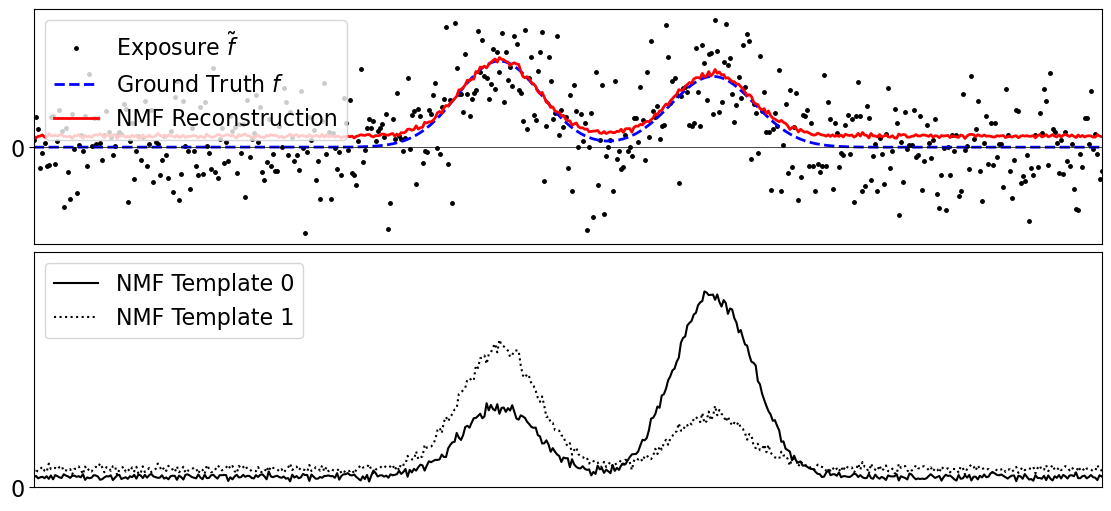

In [13]:
plt.rcParams.update({'font.size': 16})
recon = W_reg @ H_reg
idx = 120

fig, ax = plt.subplots(2, 1, figsize=(11, 5), layout="constrained")

ax[0].plot(X[:, idx], ".", c="k", ms=5, label="Exposure $\\tilde{f}$")
ax[0].plot(data[idx], label="Ground Truth $f$", c="b", ls="dashed", lw=2)
ax[0].plot(recon[:, idx], label="NMF Reconstruction", c="r", lw=2)
# ax[0].set(title="Exposure")

styles = ["solid", "dotted"]
for i in range(W_reg.shape[-1]):
    ax[1].plot(W_reg[:, i] / np.max(W_reg), ls=styles[i], c="k", label=f"NMF Template {i}")
ax[1].set(ylim=(0, 1.2))
    
xlim = (0, X.shape[-1])
for i in range(len(ax)):
    ax[i].get_xaxis().set_visible(False)
    # ax[i].get_yaxis().set_visible(False)
    ax[i].axhline(y=0, c="k", lw=0.5)
    ax[i].set(yticks=[0], yticklabels=[0],xlim=xlim)
    ax[i].legend(loc="upper left")

plt.savefig("plots/spectra_plus_templates.pdf", bbox_inches="tight", dpi=256)

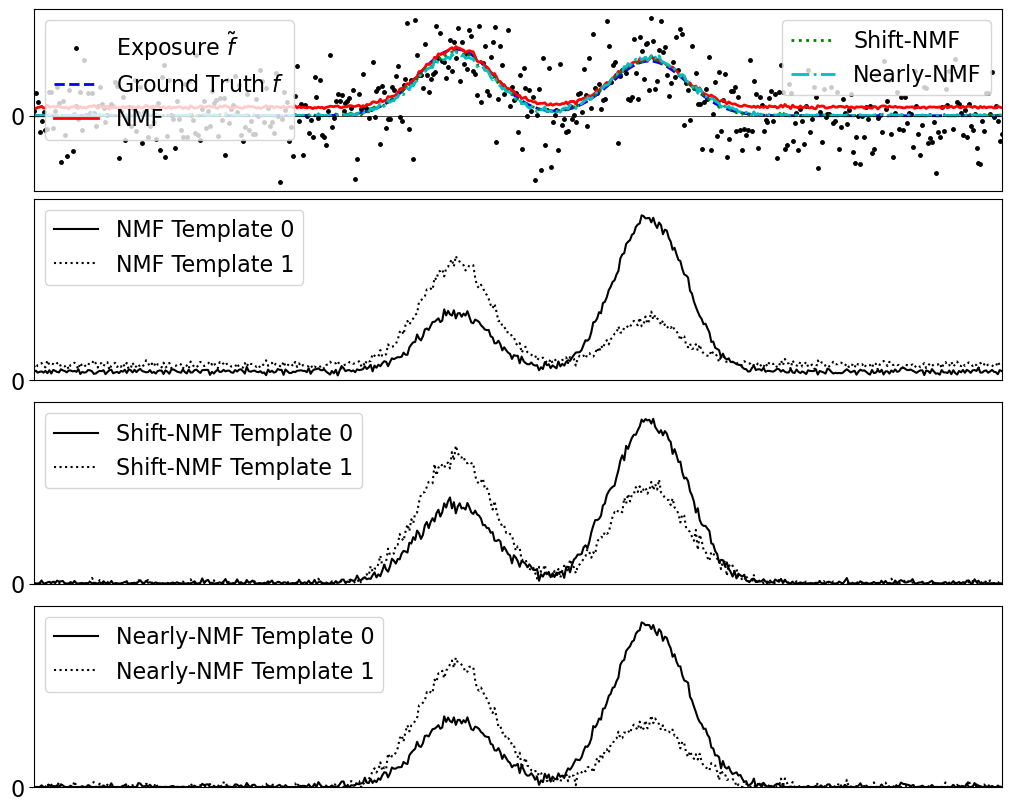

In [14]:
recon = W_reg @ H_reg
recon_nearly = W_nearly @ H_nearly
recon_shift = W_shift @ H_shift
idx = 120

fig, ax = plt.subplots(4, 1, figsize=(10, 8), layout="constrained")

left_leg = []
right_leg = []
left_leg.append(ax[0].plot(X[:, idx], ".", c="k", ms=5, label="Exposure $\\tilde{f}$")[0])
left_leg.append(ax[0].plot(data[idx], label="Ground Truth $f$", c="b", ls="dashed", lw=2)[0])
left_leg.append(ax[0].plot(recon[:, idx], label="NMF", c="r", lw=2)[0])
right_leg.append(ax[0].plot(recon_nearly[:, idx], label="Shift-NMF", c="g", lw=2, ls="dotted")[0])
right_leg.append(ax[0].plot(recon_shift[:, idx], label="Nearly-NMF", c="c", lw=2, ls="dashdot")[0])


left = ax[0].legend(handles=left_leg, loc="upper left")
right = ax[0].legend(handles=right_leg, loc="upper right")
ax[0].add_artist(left)

styles = ["solid", "dotted"]

for i in range(W_reg.shape[-1]):
    ax[1].plot(W_reg[:, i] / np.max(W_reg), ls=styles[i], c="k", label=f"NMF Template {i}")
    ax[2].plot(W_shift[:, i] / np.max(W_shift), ls=styles[i], c="k", label=f"Shift-NMF Template {i}")
    ax[3].plot(W_nearly[:, i] / np.max(W_nearly), ls=styles[i], c="k", label=f"Nearly-NMF Template {i}")
    
xlim = (0, X.shape[-1])
for i in range(len(ax)):
    ax[i].get_xaxis().set_visible(False)
    # ax[i].get_yaxis().set_visible(False)
    ax[i].axhline(y=0, c="k", lw=0.5)
    ax[i].set(yticks=[0], yticklabels=[0],xlim=xlim)
    if i > 0: ax[i].legend(loc="upper left")

for i in range(len(ax) - 1):
    ax[i + 1].set(ylim=(0, 1.1))

plt.savefig("plots/spectra_plus_all_templates.pdf", bbox_inches="tight", dpi=256)

In [15]:
nan_eps = 1e-6
def shift_nmf_arbitrary(X, V, H, W, shift=0, n_iter=100, return_chi_2=False):
    X, V = np.asarray(X) - shift, np.asarray(V)
    H, W = np.array(H_start, copy=True), np.array(W_start, copy=True)

    chi_2 = []

    # The initial chi^2 pre fitting
    if return_chi_2:
        c2 = np.sum((np.sqrt(V) * (X - (W @ H - shift))) ** 2)
        chi_2.append(c2)

    V_X = V * X # Weighted X, outside the loop for efficiency
    for i in range(n_iter):
        # H Step
        H = H * (W.T @ (V_X)) / (W.T @ (V * (W @ H - shift)))

        # Here to ensure that nans are converted to zeros.
        # If the weights are set to 0 we might end up with
        # a division by 0 and a corresponding nan/inf that needs
        # to be handled correctly
        H = np.nan_to_num(H, nan=nan_eps, posinf=nan_eps)

        W = W * ((V_X) @ H.T) / ((V * (W @ H - shift)) @ H.T)
        W = np.nan_to_num(W, nan=nan_eps, posinf=nan_eps)

        if return_chi_2:
            c2 = np.sum((np.sqrt(V) * (X - (W @ H - shift))) ** 2)
            chi_2.append(c2)

    if return_chi_2:
        return H, W, chi_2
    else:
        return H, W


In [16]:
n_runs = 10
n_iter = 50

chi_nearly = np.zeros((n_runs, n_iter + 1))
chi_shift = np.zeros_like(chi_nearly)
chi_2x = np.zeros_like(chi_shift)
chi_5x = np.zeros_like(chi_shift)

for i in range(n_runs):
    H_start = rng.uniform(0, 1, H_shape)
    W_start = np.ones(W_shape)
    
    _, _, chi_2 = nmf.nearly_NMF(X, V, H_start, W_start, n_iter=n_iter, return_chi_2=True)
    chi_nearly[i] = chi_2

    _, _, chi_2 = nmf.shift_NMF(X, V, H_start, W_start, n_iter=n_iter, return_chi_2=True)
    chi_shift[i] = chi_2

    min_shift = np.min(X)
    _, _, chi_2 = shift_nmf_arbitrary(X, V, H_start, W_start, shift=min_shift*2, n_iter=n_iter, return_chi_2=True)
    chi_2x[i] = chi_2
    
    _, _, chi_2 = shift_nmf_arbitrary(X, V, H_start, W_start, shift=min_shift*5, n_iter=n_iter, return_chi_2=True)
    chi_5x[i] = chi_2

/pscratch/sd/d/dylang/repos/nmf_with_negative_data/py/nearly_nmf/nmf.py:271: RuntimeWarning: invalid value encountered in divide
  W = W * (V_XH_pos) / ((V * (W @ H)) @ H.T + V_XH_neg)


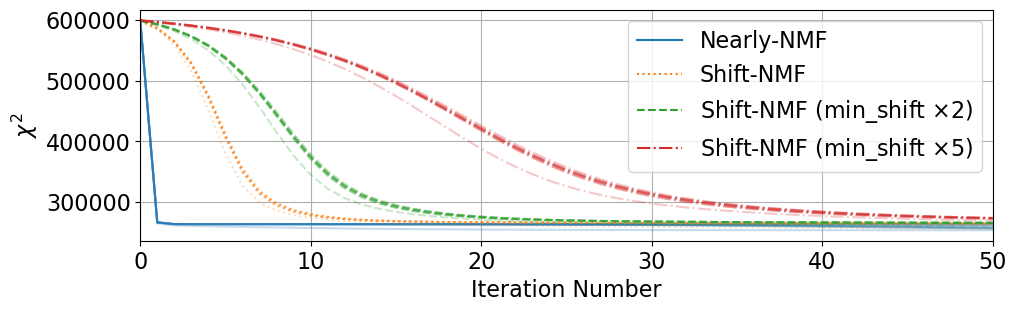

In [17]:
fig, ax = plt.subplots(figsize=(11, 3))
plt.plot(chi_nearly.T, c="C0", alpha=0.25)
plt.plot(chi_shift.T, c="C1", alpha=0.25, ls="dotted") # Shift-NMF
plt.plot(chi_2x.T, c="C2", alpha=0.25, ls="dashed")
plt.plot(chi_5x.T, c="C3", alpha=0.25, ls="dashdot")
ylim = ax.get_ylim()

plt.plot(-1, -1, c="C0", label="Nearly-NMF")
plt.plot(-1, -1, c="C1", ls="dotted", label="Shift-NMF")
plt.plot(-1, -1, c="C2", ls="dashed", label=r"Shift-NMF (min_shift $\times 2$)")
plt.plot(-1, -1, c="C3", ls="dashdot", label=r"Shift-NMF (min_shift $\times 5$)")

plt.grid()
plt.legend()
plt.xlabel("Iteration Number")
plt.ylabel("$\chi^2$")
plt.xlim(0, 50)
plt.ylim(ylim)
plt.savefig("plots/convergence_speed.pdf", bbox_inches="tight")